Notes for Chapter 3: https://d2l.ai/chapter_linear-regression/index.html 

### 3.1. Linear regression

#### 3.1.1. Basics

$\hat y = w_1 x_1 + \ldots + w_d x_d + b$

$\hat y = \textbf w^T \textbf x + b$

w is (2,1), x is (2,1) (only one observation)

It is often better to represent in matrix/vector form. 

$\hat {\textbf y} = \textbf {X}^T\textbf{w} + b$

$\hat {\textbf y} \in \mathbb{R}^{n\times 1}, \mathbf X \in \mathbb{R}^{n\times d}, \textbf w \in \mathbb{R}^{d\times 1}, b \in \mathbb{R}^{1\times 1}$, and $n$ is the number of observations, while $d$ is the number of features

#### 3.1.1.2. Loss function

$l^{(i)}(\textbf w, b) = \frac{1}{2}\left( \hat y ^{(i)} - y^{(i)}  \right)^2$

$L(\textbf w, b) = \frac{1}{n} \sum_{i=1}^n l^{(i)}(\textbf w, b) = \frac{1}{n} \sum_{i=1}^n  \frac{1}{2}\left( \textbf w^T \textbf x^{(i)} + b - y^{(i)}  \right)^2$

When training the model, we seek:

$\textbf w^*, b^* = \argmin_{\textbf w, b} L(\textbf w, b)$

#### 3.1.1.3. Analytic Solution

we can solve this by taking the bias into the parameter $\textbf w$ by appending a column of ones in the design matrix $\textbf W$. Our problem then is to minimize $||\textbf~y~-~\textbf{Xw}||^2$... this leads to solving: 

$$\textbf w^* = (\textbf{X}^T\textbf{X})^{-1} \textbf{X}^T \textbf{y}$$

#### 3.1.2. Vectorization for speed

In [3]:
# %matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l


ModuleNotFoundError: No module named 'd2l'

this example shows how using the vectoriz functions is significantly faster than using a loop. 

In [4]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

In [12]:
c = tf.Variable(tf.zeros(n))
t = time.time()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{time.time() - t:.5f} sec'

'9.57919 sec'

In [11]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00100 sec'

#### 3.1.3. Normal dist with squared loss

In [14]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

In [13]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

NameError: name 'd2l' is not defined

#### 3.1.4. linear regression as a neural network

### 3.2. Object oriented design

In [2]:
import time
import numpy as np
import tensorflow as tf
from d2l import torch as d2l


ModuleNotFoundError: No module named 'd2l'

In [16]:
def add_to_class(Class):  #@save
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [20]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [21]:
a.b

1

In [23]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [24]:
class HyperParameters:  #@save
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [25]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [26]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """Plot data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

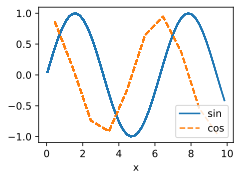

In [27]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

#### 3.2.2. Models

In [31]:
class Module(tf.keras.Model, d2l.HyperParameters):  #@save
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
        self.training = None

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def call(self, X, *args, **kwargs):
        if kwargs and "training" in kwargs:
            self.training = kwargs['training']
        return self.forward(X, *args)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.numpy(), (
            'train_' if train else 'val_') + key, every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

#### 3.2.3 Data

In [32]:
class DataModule(d2l.HyperParameters):  #@save
    def __init__(self, root='../data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

#### 3.2.4. Training

In [33]:
class Trainer(d2l.HyperParameters):  #@save
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

## 3.3. Synthetic Regression data

In [34]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

In [36]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, w.shape[0]))
        noise = tf.random.normal((n, 1)) * noise
        self.y = tf.matmul(self.X, tf.reshape(w, (-1, 1))) + b + noise

In [37]:
data = SyntheticRegressionData(w=tf.constant([2, -3.4]), b = 4.2)

In [38]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tf.Tensor([1.3008757  0.21848637], shape=(2,), dtype=float32) 
label: tf.Tensor([6.071995], shape=(1,), dtype=float32)


#### 3.3.2. Reading the dataset

In [41]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        j = tf.constant(indices[i : i+self.batch_size])
        yield tf.gather(self.X, j), tf.gather(self.y, j)

In [48]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


#### 3.3.3. Concise Implementation of the Data Loader

In [49]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [50]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


In [52]:
len(data.train_dataloader())

32

## 3.4. Linear regression from scratch